In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
np.set_printoptions(threshold=sys.maxsize)

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import tensorflow as tf

2024-09-05 13:42:37.774315: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-05 13:42:37.788414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 13:42:37.803917: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-05 13:42:37.808590: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-05 13:42:37.820866: I tensorflow/core/platform/cpu_feature_guar

In [2]:
imstack = np.load('tiles.npy', allow_pickle=True)
# imstack = imstack[...,np.newaxis]
print(imstack.shape)

(40400, 128, 128)


Number of components explaining 95% variance: 14


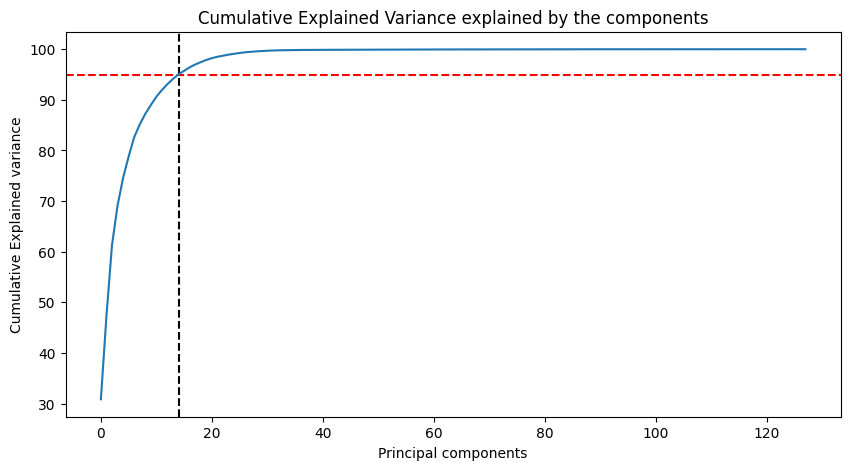

In [3]:
from sklearn.decomposition import PCA, IncrementalPCA
pca = PCA()
pca.fit(imstack[1])

# Getting the cumulative variance

var_cumu = np.cumsum(pca.explained_variance_ratio_)*100

# How many PCs explain 95% of the variance?
k = np.argmax(var_cumu>95)
print("Number of components explaining 95% variance: "+ str(k))
#print("\n")

plt.figure(figsize=[10,5])
plt.title('Cumulative Explained Variance explained by the components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axvline(x=k, color="k", linestyle="--")
plt.axhline(y=95, color="r", linestyle="--")
ax = plt.plot(var_cumu)

When looking at the first image of imstack, from 16384 pixels (128 x 128), **32** components can explain variance in the image. However, We must remember that PCA is a linear method and we would prefer to capture non-linear patterns in image data. Lets see what the spread looks like throughout the entire top_view dataset

In [4]:
components = []
for im in range(len(imstack)):
    pca = PCA()
    pca.fit(imstack[im])
    
    var_cumu = np.cumsum(pca.explained_variance_ratio_)*100
    k = np.argmax(var_cumu > 95)
    components.append(k)

In [5]:
from pandas import DataFrame

df = DataFrame(components)
df = df.rename(columns={0:'K_components'})

In [6]:
df.describe()

,K_components
count,40400.000000
mean,9.670668
std,3.733880
min,1.000000
25%,7.000000
50%,9.000000
75%,11.000000
max,58.000000


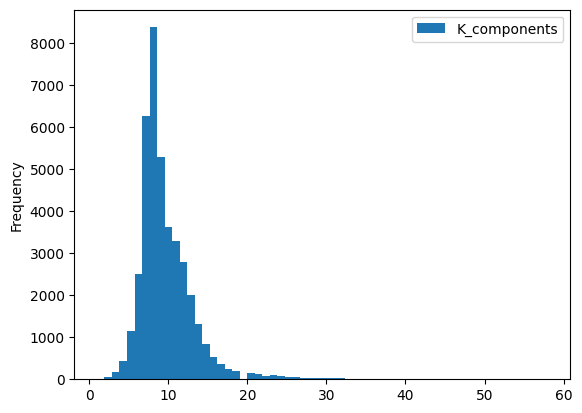

In [7]:
df.plot.hist(bins=60, grid=False).get_figure().savefig('K_components_explaining_variance.png')

From this PCA reduction, we find that the number of components (K) needed to explain the most important features can be explained of images in the *top_view* dataset is positively skewed around 8 (mode) / 9.7 (mean) for images of (128px by 128px) . Therefore, we could set the latent dimension to this reduced dimensionality.

2024-09-05 13:46:47.760534: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1110 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:2d:00.0, compute capability: 8.6


<function matplotlib.pyplot.show(close=None, block=None)>

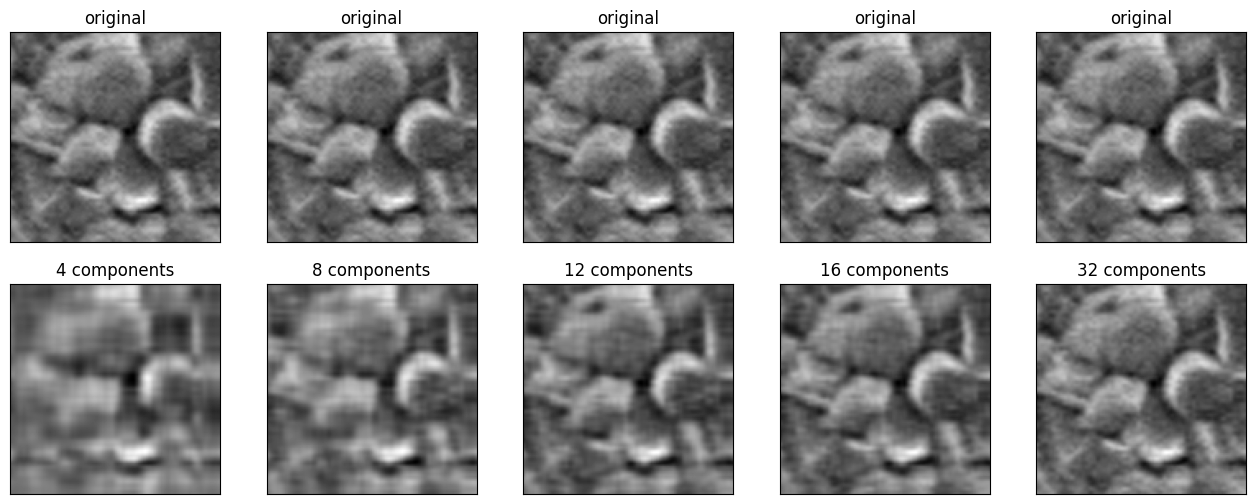

In [8]:
comp = [4,8,12,16,32]
im = np.random.randint(0, len(imstack)-1)

plt.figure(figsize=(16, 6))
for k in range(len(comp)):
    ipca = IncrementalPCA(n_components= comp[k])
    imstack_recon = ipca.inverse_transform(ipca.fit_transform(imstack[im]))
    
    # display original
    ax = plt.subplot(2, len(comp), k + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(imstack[im]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    #display reconstruction
    bx = plt.subplot(2, len(comp), k + len(comp) + 1)
    plt.title(f"{comp[k]} components")
    plt.imshow(imstack_recon)
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show

Using PCA, we can see the effect of increasing the number of components with image reconstruction. At the lower end, the loss in quality is high and increases with added components. Contrarily, on the higher end, there is visually little difference reconstructed images. So we can assume that a good latent space dimension for the VAE would be around 12, not 8/9.

In [10]:
from sklearn.manifold import TSNE

Inspiration from:

- https://www.kaggle.com/code/mirzarahim/introduction-to-pca-image-compression-example
- https://www.kaggle.com/code/hamishdickson/preprocessing-images-with-dimensionality-reduction
- https://www.tensorflow.org/tutorials/generative/autoencoder#second_example_image_denoising

In [12]:
imstack.shape[-2:]

(128, 128)

In [13]:
X = imstack.reshape(*imstack.shape[:-2], -1)
X.shape

(40400, 16384)

In [ ]:
%%time
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_scaled

In [14]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)
tsne.kl_divergence_

3.6590328216552734

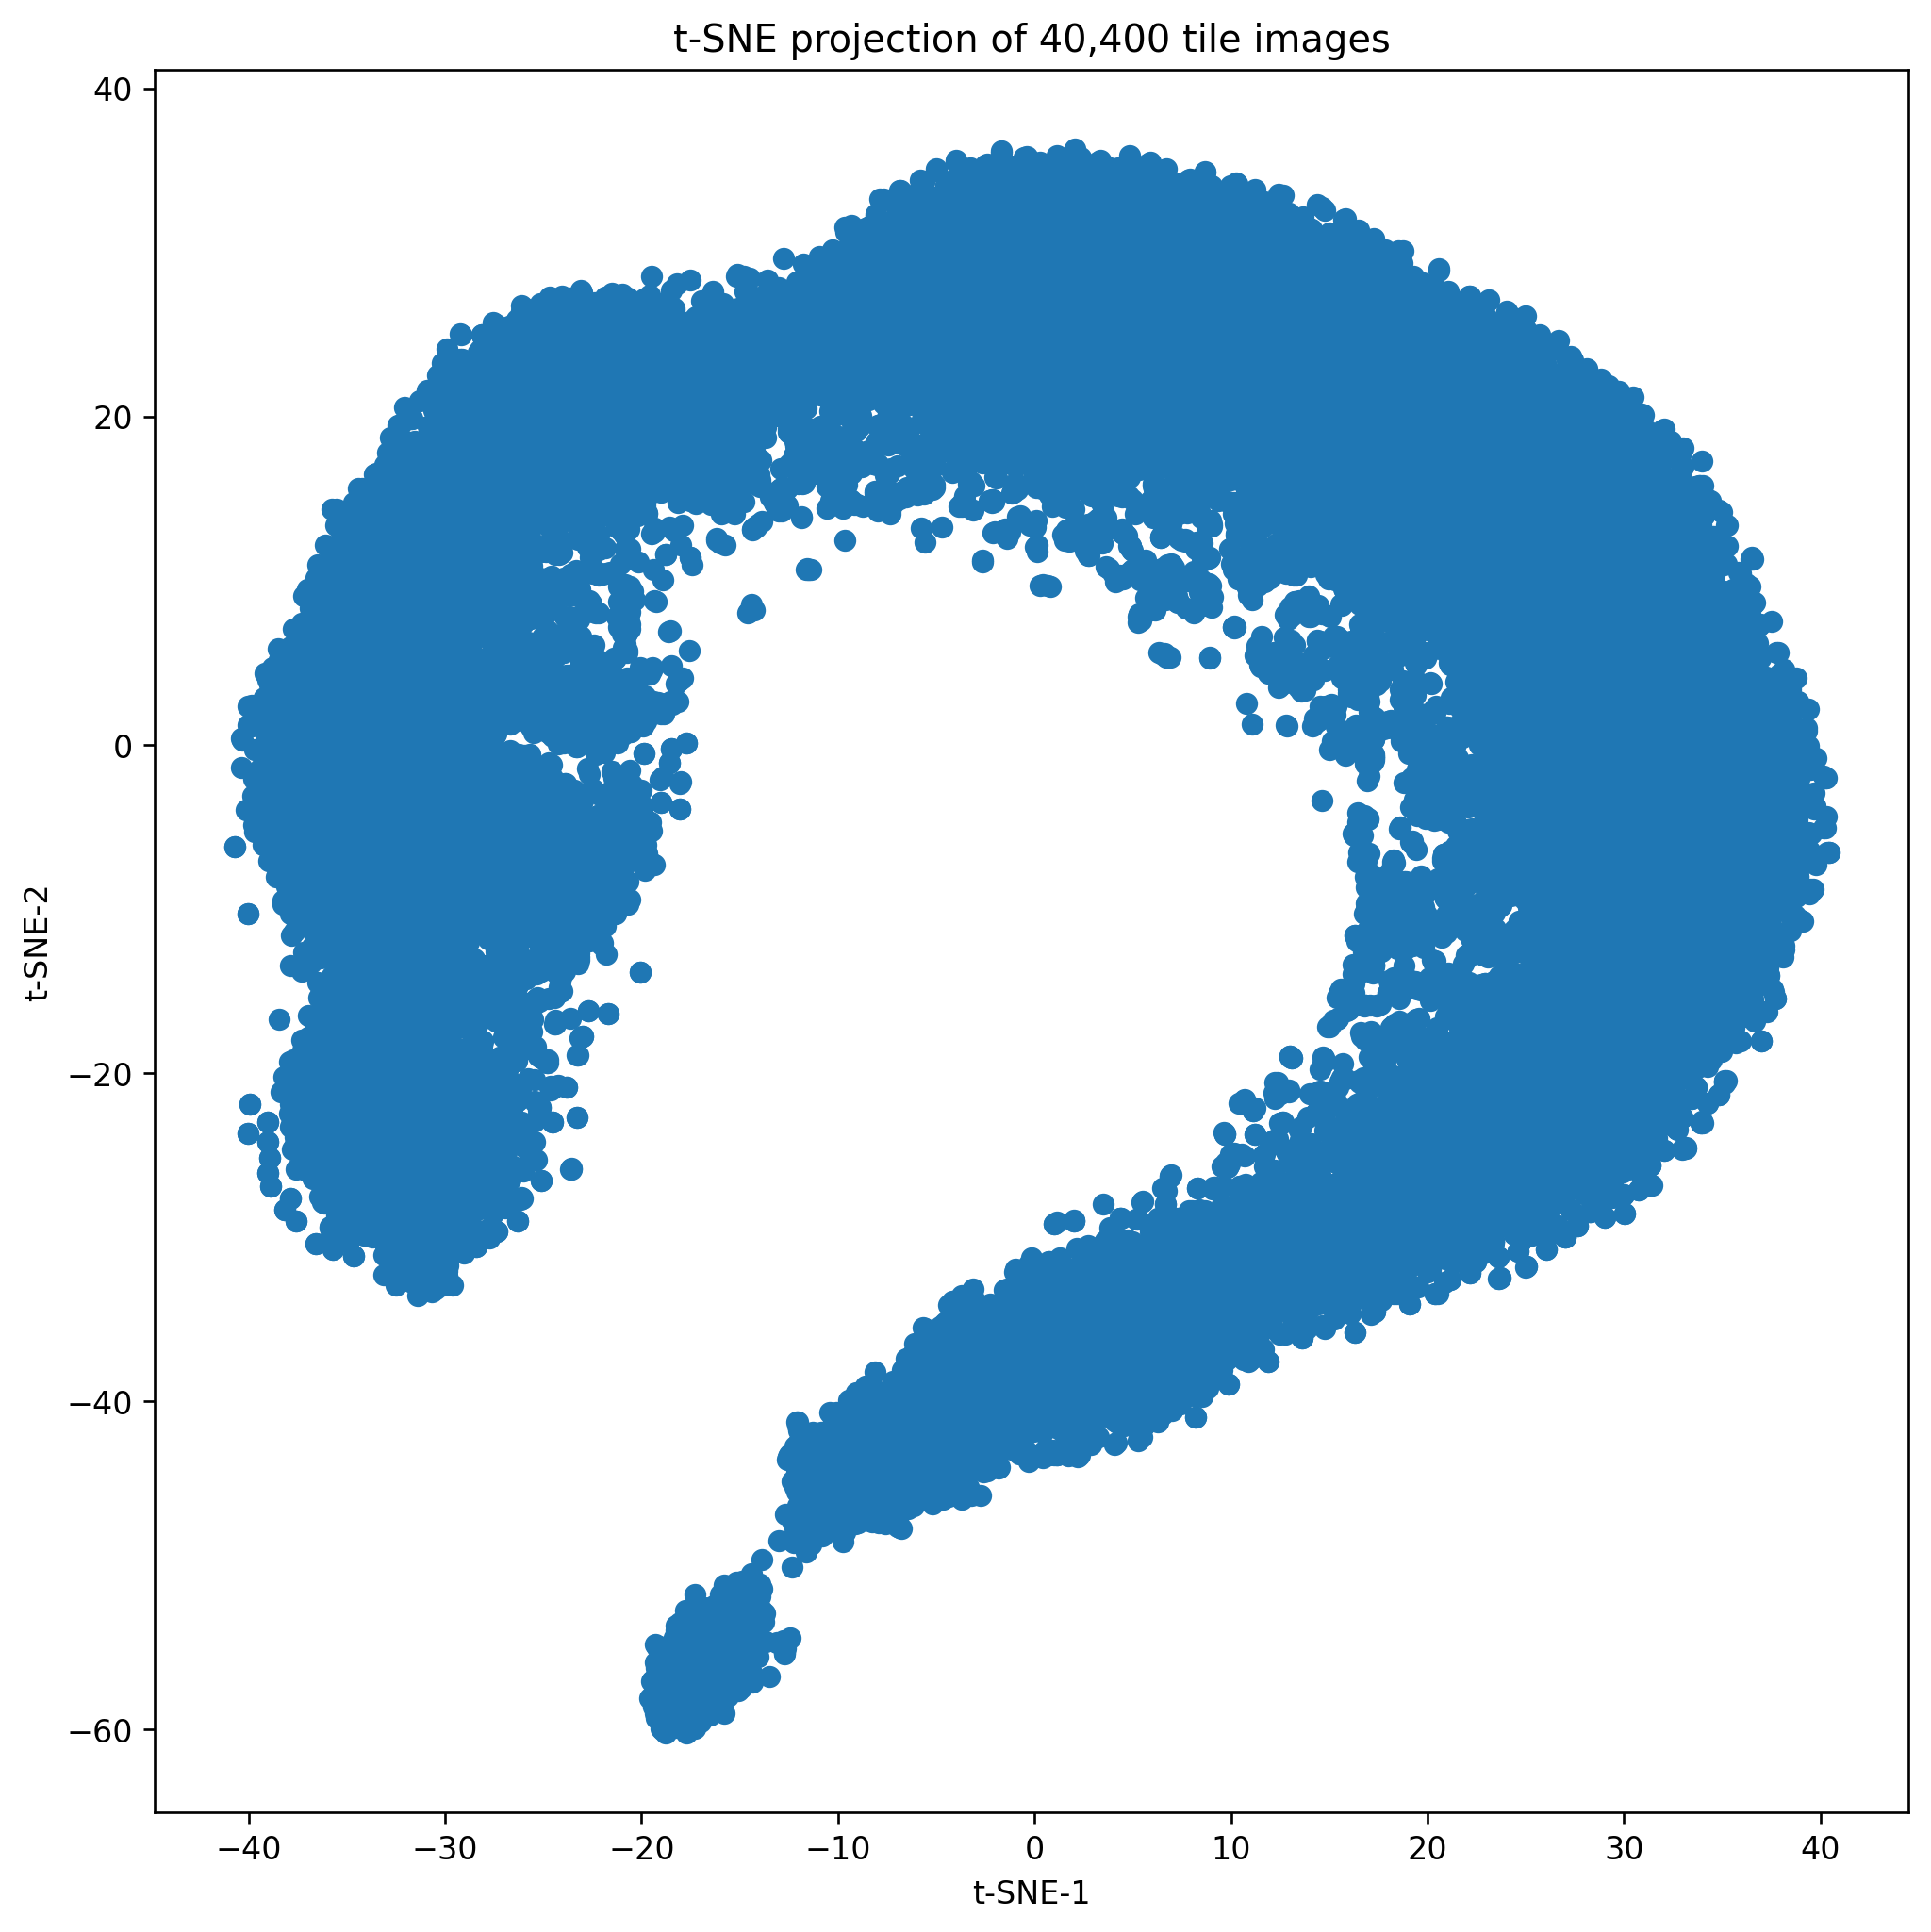

In [19]:
x=X_tsne[:,0]
y=X_tsne[:,1]

plt.figure(figsize=(10,10),dpi=240)
plt.scatter(x, y)
plt.title("t-SNE projection of 40,400 tile images")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
# plt.savefig('tSNE_viz_2comp.png')
plt.show()

-18.076336 -58.89631
-15.931843 -55.719345
-15.101379 -54.030773


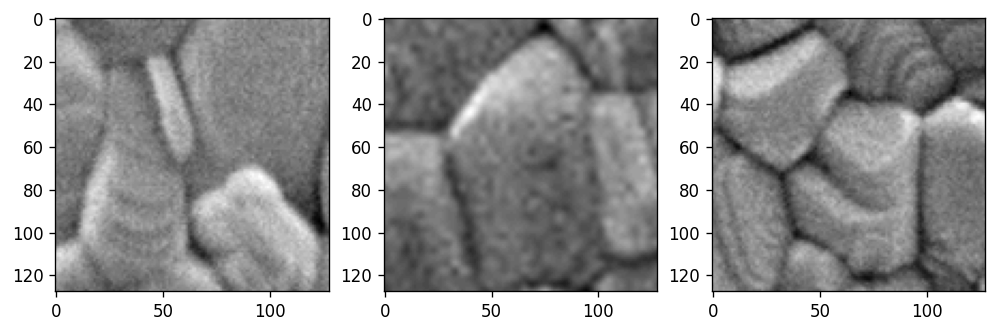

In [16]:
plt.figure(figsize=(10,10), dpi = 120)
plt.subplot(131)
print(x[2716],y[2716])
plt.imshow(imstack[2716])
plt.subplot(132)
print(x[28852],y[28852])
plt.imshow(imstack[28852])
plt.subplot(133)
print(x[36320],y[36320])
plt.imshow(imstack[36320])
plt.show()

In [17]:
%%time

tsne_1 = TSNE(n_components=2, perplexity = 100,verbose = 1, random_state=42)
X_tsne_1 = tsne_1.fit_transform(X)
tsne_1.kl_divergence_

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 40400 samples in 0.246s...
[t-SNE] Computed neighbors for 40400 samples in 70.577s...
[t-SNE] Computed conditional probabilities for sample 1000 / 40400
[t-SNE] Computed conditional probabilities for sample 2000 / 40400
[t-SNE] Computed conditional probabilities for sample 3000 / 40400
[t-SNE] Computed conditional probabilities for sample 4000 / 40400
[t-SNE] Computed conditional probabilities for sample 5000 / 40400
[t-SNE] Computed conditional probabilities for sample 6000 / 40400
[t-SNE] Computed conditional probabilities for sample 7000 / 40400
[t-SNE] Computed conditional probabilities for sample 8000 / 40400
[t-SNE] Computed conditional probabilities for sample 9000 / 40400
[t-SNE] Computed conditional probabilities for sample 10000 / 40400
[t-SNE] Computed conditional probabilities for sample 11000 / 40400
[t-SNE] Computed conditional probabilities for sample 12000 / 40400
[t-SNE] Computed conditional probabilities for s

2.6946418285369873

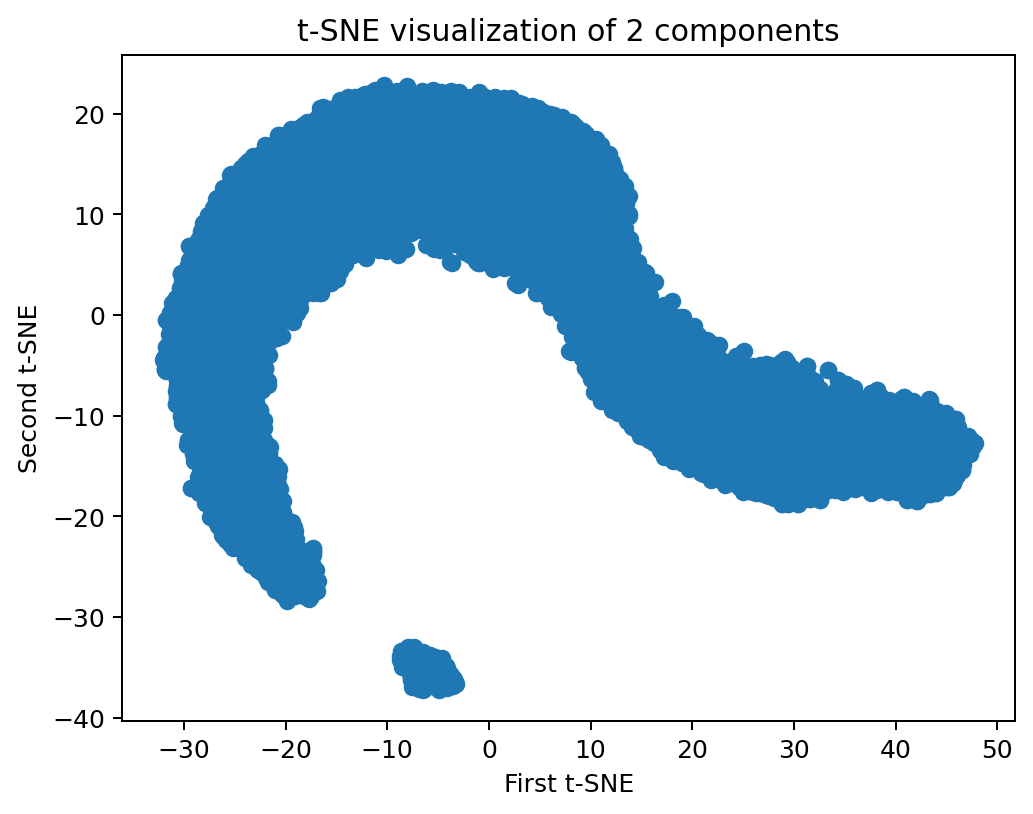

In [18]:
x_1=X_tsne_1[:,0]
y_1=X_tsne_1[:,1]

plt.figure(dpi=180)
plt.scatter(x_1, y_1)
plt.title("t-SNE visualization of 2 components")
plt.xlabel("First t-SNE")
plt.ylabel("Second t-SNE")

plt.show()